In [ ]:
!pip install ultralytics opencv-python torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.1/899.1 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.2
    Uninstalling numpy-2.1.2:
      Successfully uninstalled numpy-2.1.2


In [ ]:
import os
import random
import shutil
from ultralytics import YOLO
import cv2
import torch
from sklearn.model_selection import train_test_split

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/decoliu/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
#@title Pull Data
#### Pull's the standardized Data from our shared Google Drive Location
## Refer to "20241010SpineMarking_PoYu.ipynb" for the steps used to clean the original archive data and turn it into our usable data

import os
import glob
import pandas as pd
from PIL import Image

# Import the jpg files
main_folder = '/content/drive/MyDrive/Machine_Learning_Project2024/Data'

# Initialize DataFrame with the correct columns
Data = pd.DataFrame(columns=['file_name', 'image'])

# Import the csv data
file_path_coord = '/content/drive/MyDrive/Machine_Learning_Project2024/Data/coords_pretrain.csv'

position = pd.read_csv(file_path_coord)
position['file_name'] = position.apply(lambda row: f"processed_{row['source']}_jpgs_{row['filename']}", axis=1)
pivoted = position.pivot_table(index=['file_name'],
                               columns='level',
                               values=['x', 'y'],
                               aggfunc='first')

pivoted.columns = [f'{level}_{coord}' for coord, level in pivoted.columns]
pivoted.reset_index(inplace=True)

# Merge image and coord position
Data = pd.merge(pivoted, Data, on='file_name', how='left')

Data.reset_index(inplace=True)

# Load images into the DataFrame in order
image_files = sorted(glob.glob(os.path.join(main_folder, '*.jpg')))
image_dict = {os.path.basename(file_path): Image.open(file_path) for file_path in image_files}

### Try to iterate through all of the images, test if the image name matches the respective row in the data
### Upon matching, then assign the image
for i, row in Data.iterrows():
    file_name = row['file_name']
    if file_name in image_dict:
        Data.at[i, 'image'] = image_dict[file_name]  # Use .at for assignment based on index

# Display the DataFrame
display(Data)

,index,file_name,L1/L2_x,L2/L3_x,L3/L4_x,L4/L5_x,L5/S1_x,L1/L2_y,L2/L3_y,L3/L4_y,L4/L5_y,L5/S1_y,image
0,0,processed_lsd_jpgs_0001.jpg,101,92,89,88,91,77,106,138,166,189,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,1,processed_lsd_jpgs_0002.jpg,113,105,100,99,104,68,100,132,167,198,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,2,processed_lsd_jpgs_0003.jpg,169,164,158,153,152,57,89,123,157,188,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,3,processed_lsd_jpgs_0004.jpg,143,136,133,138,147,63,95,125,158,183,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,4,processed_lsd_jpgs_0005.jpg,139,134,128,128,131,71,101,134,168,190,<PIL.JpegImagePlugin.JpegImageFile image mode=...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,1116,processed_tseg_jpgs_case_1201.jpg,131,126,123,125,132,82,110,141,169,195,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1117,1117,processed_tseg_jpgs_case_1217.jpg,126,123,118,115,119,81,111,142,169,196,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1118,1118,processed_tseg_jpgs_case_1221.jpg,133,123,114,112,122,80,110,139,168,193,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1119,1119,processed_tseg_jpgs_case_1223.jpg,125,114,108,110,119,85,109,137,167,193,<PIL.JpegImagePlugin.JpegImageFile image mode=...


# Data Preparation for YOLO


In [ ]:
import pandas as pd
import os

# Function to normalize bounding boxes and save in YOLO format
def normalize_and_save_yolo(data, output_dir="/content/drive/MyDrive/Machine_Learning_Project2024/Data/labels"):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    for index, row in data.iterrows():
        # Get image dimensions
        img_width, img_height = row['image'].size  # Assuming PIL Image format

        # Initialize annotation list
        annotations = []

        # Corrected loop to include only existing column pairs
        for i, pair in enumerate(['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']):  # Use valid pairs
            x_min = row[f"{pair}_x"]
            y_min = row[f"{pair}_y"]
            x_max = x_min + 5  # Adjust bounding box width
            y_max = y_min + 5  # Adjust bounding box height

            # Normalize bounding box (scale coordinates to 0-1)
            x_center = ((x_min + x_max) / 2) / img_width
            y_center = ((y_min + y_max) / 2) / img_height
            width = (x_max - x_min) / img_width
            height = (y_max - y_min) / img_height

            # Append normalized bounding box to annotations
            annotations.append(f"{i} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

        # Save annotations to a .txt file
        annotation_file = os.path.join(output_dir, row['file_name'].replace('.jpg', '.txt'))
        with open(annotation_file, 'w') as f:
            f.write("\n".join(annotations))

    print(f"Annotations saved in '{output_dir}'")

# Usage
normalize_and_save_yolo(Data)

KeyboardInterrupt: 

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to the folder containing your images and labels
main_folder = '/content/drive/MyDrive/Machine_Learning_Project2024/Data'
labels_folder = os.path.join(main_folder, "labels")  # Assuming all labels are in 'labels/'

# Output folder to store the organized dataset
output_dir = '/content/drive/MyDrive/Machine_Learning_Project2024/Data'
train_images_dir = os.path.join(output_dir, 'train/images')
val_images_dir = os.path.join(output_dir, 'val/images')
test_images_dir = os.path.join(output_dir, 'test/images')

train_labels_dir = os.path.join(output_dir, 'train/labels')
val_labels_dir = os.path.join(output_dir, 'val/labels')
test_labels_dir = os.path.join(output_dir, 'test/labels')

# Create output directories for train, val, and test splits
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)

os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)

# List all .jpg files in the directory
image_files = sorted([file for file in os.listdir(main_folder) if file.lower().endswith('.jpg')])

# Check if any images are found
if len(image_files) == 0:
    raise ValueError(f"No image files found in {main_folder}. Ensure the directory contains .jpg images.")

# Split the images into train, validation, and test sets
train_files, temp_files = train_test_split(image_files, test_size=0.3, random_state=42)  # 70% training
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)     # 15% validation, 15% testing

# Function to move images and their corresponding labels
def move_files(file_list, source_dir, dest_images_dir, dest_labels_dir):
    for file_name in file_list:
        # Move image
        src_image_path = os.path.join(source_dir, file_name)
        dest_image_path = os.path.join(dest_images_dir, file_name)
        shutil.copy(src_image_path, dest_image_path)  # Copy the image

        # Move corresponding label
        label_file_name = file_name.replace('.jpg', '.txt')  # Label file should match the image name
        src_label_path = os.path.join(labels_folder, label_file_name)
        dest_label_path = os.path.join(dest_labels_dir, label_file_name)
        if os.path.exists(src_label_path):  # Check if label exists
            shutil.copy(src_label_path, dest_label_path)

# Move files to the respective directories
move_files(train_files, main_folder, train_images_dir, train_labels_dir)
move_files(val_files, main_folder, val_images_dir, val_labels_dir)
move_files(test_files, main_folder, test_images_dir, test_labels_dir)

print("Dataset split successfully!")

In [ ]:
import os

# Paths to datasets
base_path = '/content/drive/MyDrive/Machine_Learning_Project2024/Data'
datasets = ['train', 'val', 'test']  # List of datasets to check

# Function to verify images and labels
def verify_images_and_labels(base_path, datasets):
    for dataset in datasets:
        images_path = os.path.join(base_path, dataset, 'images')
        labels_path = os.path.join(base_path, dataset, 'labels')

        # Get lists of image and label files
        image_files = sorted([f.replace('.jpg', '') for f in os.listdir(images_path) if f.endswith('.jpg')])
        label_files = sorted([f.replace('.txt', '') for f in os.listdir(labels_path) if f.endswith('.txt')])

        # Find mismatches
        missing_labels = [f + '.jpg' for f in image_files if f not in label_files]
        missing_images = [f + '.txt' for f in label_files if f not in image_files]

        # Print results
        print(f"--- {dataset.upper()} DATASET ---")
        print(f"Total images: {len(image_files)}, Total labels: {len(label_files)}")
        if missing_labels:
            print(f"Images missing labels: {missing_labels}")
        else:
            print("All images have corresponding labels.")

        if missing_images:
            print(f"Labels missing images: {missing_images}")
        else:
            print("All labels have corresponding images.")
        print("\n")

# Run the verification
verify_images_and_labels(base_path, datasets)

In [ ]:
import os

# Paths to your dataset
base_path = '/content/drive/MyDrive/Machine_Learning_Project2024/Data'
datasets = ['train', 'val', 'test']  # Datasets to process

# Loop through each dataset
for dataset in datasets:
    images_dir = os.path.join(base_path, dataset, 'images')
    labels_dir = os.path.join(base_path, dataset, 'labels')

    # Ensure labels directory exists
    os.makedirs(labels_dir, exist_ok=True)

    # Process each image
    for image_file in os.listdir(images_dir):
        if image_file.endswith('.jpg'):
            label_file = image_file.replace('.jpg', '.txt')
            label_path = os.path.join(labels_dir, label_file)

            # If label file doesn't exist, create an empty one
            if not os.path.exists(label_path):
                open(label_path, 'w').close()  # Create an empty file
                print(f"Created empty label file: {label_path}")

In [ ]:
import yaml

# Define the paths to your train and validation image folders
dataset_base_path = '/content/drive/MyDrive/Machine_Learning_Project2024/Data'
train_path = f"{dataset_base_path}/train/images"
val_path = f"{dataset_base_path}/val/images"

# Define the 5 classes (replace with your actual class names)
class_names = ['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']

# Create the YAML content
data_yaml = {
    'train': train_path,
    'val': val_path,
    'nc': len(class_names),  # Number of classes
    'names': class_names  # Class names
}

# Save the data.yaml file
yaml_path = f"{dataset_base_path}/data.yaml"
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

print(f"data.yaml created at {yaml_path}")

yaml_path = '/content/drive/MyDrive/Machine_Learning_Project2024/Data/data.yaml'

with open(yaml_path, 'r') as file:
    data_yaml_contents = file.read()

print("Contents of data.yaml:")
print(data_yaml_contents)

# Model Training

In [ ]:
model = YOLO('yolov8m.pt')  # Load pre-trained YOLOv8 model
# Train the model
model.train(
    data='/content/drive/MyDrive/Machine_Learning_Project2024/Data/data.yaml',  # Path to your dataset YAML file
    epochs=100,  # Number of epochs
    imgsz=256,  # Match your image size
    batch=16,  # Batch size
    device='cuda'  # Use GPU if available
)

100%|██████████| 49.7M/49.7M [00:00<00:00, 372MB/s]


Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/Machine_Learning_Project2024/Data/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sho

100%|██████████| 755k/755k [00:00<00:00, 70.7MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 390MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/.shortcut-targets-by-id/1Idi7JVoN_7UkG6hI4qmgGb0g06trUH4U/Machine_Learning_Project2024/Data/train/labels.cache... 865 images, 79 backgrounds, 0 corrupt: 100%|██████████| 865/865 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/.shortcut-targets-by-id/1Idi7JVoN_7UkG6hI4qmgGb0g06trUH4U/Machine_Learning_Project2024/Data/val/labels.cache... 186 images, 26 backgrounds, 0 corrupt: 100%|██████████| 186/186 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.49G     0.6561      70.04     0.1835         89        256:  11%|█         | 6/55 [00:33<04:31,  5.53s/it]


KeyboardInterrupt: 

In [ ]:
# Load the trained model weights
model = YOLO('/content/drive/MyDrive/Machine_Learning_Project2024/weights/best.pt')

# Resume training
model.train(data='/content/drive/MyDrive/Machine_Learning_Project2024/Data/data.yaml', epochs=100, imgsz=256, batch=16, lr0=0.001)

Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Machine_Learning_Project2024/weights/best.pt, data=/content/drive/MyDrive/Machine_Learning_Project2024/Data/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fa

train: Scanning /content/drive/.shortcut-targets-by-id/1Idi7JVoN_7UkG6hI4qmgGb0g06trUH4U/Machine_Learning_Project2024/Data/train/labels.cache... 865 images, 79 backgrounds, 0 corrupt: 100%|██████████| 865/865 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/.shortcut-targets-by-id/1Idi7JVoN_7UkG6hI4qmgGb0g06trUH4U/Machine_Learning_Project2024/Data/val/labels.cache... 186 images, 26 backgrounds, 0 corrupt: 100%|██████████| 186/186 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.59G      2.593      1.325     0.7599         13        256: 100%|██████████| 55/55 [00:19<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        186        800      0.467      0.427      0.365      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.849G      2.749      1.371     0.7652          7        256: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.33it/s]


                   all        186        800      0.435       0.41      0.352      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.847G      2.832      1.477     0.7776          6        256: 100%|██████████| 55/55 [00:09<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]


                   all        186        800      0.441      0.393      0.323     0.0919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.847G      2.828      1.474     0.7795          5        256: 100%|██████████| 55/55 [00:10<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.48it/s]

                   all        186        800      0.427      0.407      0.309     0.0897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.856G      2.748      1.475     0.7757          3        256: 100%|██████████| 55/55 [00:12<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]

                   all        186        800      0.391      0.396      0.299     0.0857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.866G      2.794      1.474     0.7852          3        256: 100%|██████████| 55/55 [00:11<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        186        800       0.41      0.346      0.284     0.0791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.849G      2.824      1.492     0.7786          5        256: 100%|██████████| 55/55 [00:09<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


                   all        186        800      0.415      0.417      0.322     0.0891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.847G       2.77      1.436     0.7803          5        256: 100%|██████████| 55/55 [00:10<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

                   all        186        800      0.426      0.325      0.269     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.856G      2.848      1.441     0.7775          7        256: 100%|██████████| 55/55 [00:12<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]

                   all        186        800      0.405      0.412      0.316     0.0889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.851G      2.836      1.455     0.7804          2        256: 100%|██████████| 55/55 [00:14<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

                   all        186        800      0.431      0.358      0.299     0.0819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.851G      2.876      1.476     0.7691          8        256: 100%|██████████| 55/55 [00:13<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]


                   all        186        800       0.42      0.342      0.277      0.072

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.847G      2.691      1.405     0.7669          0        256: 100%|██████████| 55/55 [00:09<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]


                   all        186        800      0.352      0.386      0.265     0.0754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.858G      2.759      1.405     0.7803          9        256: 100%|██████████| 55/55 [00:10<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]


                   all        186        800      0.454      0.395      0.338        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.847G      2.781      1.456     0.7765          8        256: 100%|██████████| 55/55 [00:12<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.47it/s]

                   all        186        800      0.455      0.409      0.341     0.0952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.847G      2.707       1.39     0.7625          0        256: 100%|██████████| 55/55 [00:11<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        186        800      0.447      0.414      0.333     0.0936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.851G      2.774      1.495     0.7737          4        256: 100%|██████████| 55/55 [00:09<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

                   all        186        800      0.464      0.408      0.358      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.854G      2.723      1.394     0.7777          7        256: 100%|██████████| 55/55 [00:10<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]

                   all        186        800      0.488      0.415      0.343     0.0957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.851G       2.74      1.419     0.7734          6        256: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]

                   all        186        800      0.466      0.385      0.327     0.0943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.864G      2.745      1.425     0.7794          4        256: 100%|██████████| 55/55 [00:11<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]


                   all        186        800       0.49      0.412      0.363      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.847G      2.702       1.37     0.7722          5        256: 100%|██████████| 55/55 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

                   all        186        800      0.455      0.392      0.326     0.0912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.837G      2.737      1.354     0.7818          6        256: 100%|██████████| 55/55 [00:10<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.59it/s]


                   all        186        800      0.471      0.421      0.354      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.851G      2.713      1.414     0.7566          0        256: 100%|██████████| 55/55 [00:12<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]

                   all        186        800       0.46      0.405      0.336     0.0948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.847G        2.7      1.345     0.7612          1        256: 100%|██████████| 55/55 [00:11<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

                   all        186        800      0.449      0.386      0.324      0.097



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.843G      2.724      1.357     0.7807          4        256: 100%|██████████| 55/55 [00:09<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]

                   all        186        800      0.476      0.384      0.339     0.0958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.856G      2.693       1.36     0.7748          5        256: 100%|██████████| 55/55 [00:11<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]

                   all        186        800      0.436      0.379      0.331     0.0933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.847G      2.718      1.327     0.7744         13        256: 100%|██████████| 55/55 [00:12<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.94it/s]

                   all        186        800       0.46      0.423      0.356      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.864G      2.675      1.383     0.7857          5        256: 100%|██████████| 55/55 [00:11<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        186        800      0.454      0.407      0.328     0.0909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.866G      2.685      1.331      0.775          5        256: 100%|██████████| 55/55 [00:09<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.97it/s]

                   all        186        800      0.492      0.432      0.396      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.856G      2.696      1.309     0.7743          3        256: 100%|██████████| 55/55 [00:11<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.63it/s]

                   all        186        800      0.475       0.44      0.389      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.864G      2.623      1.278      0.776          3        256: 100%|██████████| 55/55 [00:12<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]


                   all        186        800      0.415      0.409      0.327     0.0924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.851G      2.667       1.33     0.7653         20        256: 100%|██████████| 55/55 [00:10<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

                   all        186        800      0.473      0.444       0.39      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      0.86G      2.649      1.312     0.7807          5        256: 100%|██████████| 55/55 [00:09<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

                   all        186        800      0.425      0.371      0.337     0.0969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.856G      2.672      1.311      0.775          5        256: 100%|██████████| 55/55 [00:11<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]

                   all        186        800      0.487      0.396      0.361      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.849G       2.67      1.311     0.7664         14        256: 100%|██████████| 55/55 [00:12<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]

                   all        186        800      0.511      0.427      0.385      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.849G      2.633      1.293     0.7536          5        256: 100%|██████████| 55/55 [00:10<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        186        800      0.466      0.429      0.351      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.864G      2.719      1.315     0.7827          5        256: 100%|██████████| 55/55 [00:09<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.59it/s]


                   all        186        800      0.481      0.373      0.352      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.833G      2.685      1.369     0.7785         13        256: 100%|██████████| 55/55 [00:11<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.65it/s]


                   all        186        800      0.467      0.416       0.34      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.864G      2.722      1.305     0.7803          5        256: 100%|██████████| 55/55 [00:12<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]

                   all        186        800      0.489      0.388      0.342      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.851G      2.622      1.331     0.7565          2        256: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        186        800      0.471      0.421      0.358      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      0.86G      2.685      1.304     0.7766          5        256: 100%|██████████| 55/55 [00:10<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.24it/s]

                   all        186        800       0.45      0.369      0.304     0.0907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.856G      2.678      1.324     0.7754          4        256: 100%|██████████| 55/55 [00:12<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.53it/s]


                   all        186        800       0.45      0.337      0.305     0.0828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.849G      2.625      1.344     0.7678          5        256: 100%|██████████| 55/55 [00:12<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.92it/s]

                   all        186        800      0.449      0.382      0.326     0.0924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.847G      2.669      1.303     0.7598          6        256: 100%|██████████| 55/55 [00:09<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.45it/s]

                   all        186        800      0.471      0.411      0.355      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.864G      2.651      1.293     0.7683         16        256: 100%|██████████| 55/55 [00:10<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]


                   all        186        800      0.477      0.412       0.36      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.839G      2.616      1.276     0.7706          2        256: 100%|██████████| 55/55 [00:12<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.43it/s]

                   all        186        800      0.494      0.425      0.369      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.847G      2.637      1.283     0.7721          5        256: 100%|██████████| 55/55 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.12it/s]

                   all        186        800      0.508      0.399      0.382       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.847G      2.601       1.34     0.7737          4        256: 100%|██████████| 55/55 [00:10<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        186        800      0.488      0.437      0.383      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.847G      2.553      1.258     0.7655          0        256: 100%|██████████| 55/55 [00:09<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.52it/s]


                   all        186        800       0.48       0.43      0.378      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.837G      2.668      1.248     0.7806          4        256: 100%|██████████| 55/55 [00:12<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        186        800      0.489      0.416      0.369       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.851G      2.603      1.233     0.7607          2        256: 100%|██████████| 55/55 [00:12<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]

                   all        186        800      0.482      0.405      0.343      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.849G       2.58       1.26     0.7813          2        256: 100%|██████████| 55/55 [00:10<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

                   all        186        800       0.51      0.428      0.378      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.851G       2.65      1.222     0.7744          5        256: 100%|██████████| 55/55 [00:09<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]

                   all        186        800      0.475      0.426      0.357       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.835G      2.611       1.29     0.7663          5        256: 100%|██████████| 55/55 [00:12<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.46it/s]

                   all        186        800      0.494      0.417      0.358      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.851G      2.598      1.245      0.776          4        256: 100%|██████████| 55/55 [00:12<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]


                   all        186        800      0.483       0.42      0.367      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.847G      2.597      1.264     0.7739          3        256: 100%|██████████| 55/55 [00:10<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

                   all        186        800      0.519      0.448      0.395       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.851G      2.599      1.246     0.7793          4        256: 100%|██████████| 55/55 [00:09<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.59it/s]


                   all        186        800      0.519      0.474      0.432      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.854G      2.584      1.242     0.7624          7        256: 100%|██████████| 55/55 [00:11<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.37it/s]

                   all        186        800      0.501      0.448      0.404      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.845G       2.57      1.245     0.7779          5        256: 100%|██████████| 55/55 [00:12<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]

                   all        186        800      0.514      0.422      0.404      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.851G      2.556      1.249     0.7701         10        256: 100%|██████████| 55/55 [00:10<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        186        800      0.491      0.452      0.402       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.845G       2.57      1.222     0.7717          4        256: 100%|██████████| 55/55 [00:09<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]


                   all        186        800      0.492      0.426      0.393      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.839G       2.59      1.231     0.7595          7        256: 100%|██████████| 55/55 [00:12<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]

                   all        186        800      0.517       0.44      0.409      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.851G       2.51      1.219     0.7546          5        256: 100%|██████████| 55/55 [00:12<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]


                   all        186        800      0.515      0.432      0.404      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.847G      2.584       1.21     0.7735          5        256: 100%|██████████| 55/55 [00:10<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]

                   all        186        800       0.52      0.463       0.44       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.849G      2.595      1.221     0.7586          5        256: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.60it/s]

                   all        186        800      0.506      0.453      0.412      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.843G      2.544      1.196     0.7641          5        256: 100%|██████████| 55/55 [00:12<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.02it/s]

                   all        186        800      0.509      0.437      0.399      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.847G      2.569      1.209     0.7669          5        256: 100%|██████████| 55/55 [00:12<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.42it/s]


                   all        186        800      0.493      0.427      0.394       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.847G      2.568      1.194     0.7675          4        256: 100%|██████████| 55/55 [00:10<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]

                   all        186        800      0.524      0.466       0.44      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.851G      2.489      1.185     0.7632          0        256: 100%|██████████| 55/55 [00:10<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.59it/s]


                   all        186        800      0.507      0.455      0.422      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.839G       2.55      1.176     0.7746          5        256: 100%|██████████| 55/55 [00:12<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.25it/s]

                   all        186        800      0.527      0.463      0.422      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.851G      2.529      1.172     0.7567          0        256: 100%|██████████| 55/55 [00:12<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]

                   all        186        800      0.501      0.431      0.401      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.849G      2.564      1.214     0.7661         12        256: 100%|██████████| 55/55 [00:10<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        186        800      0.519      0.444      0.404      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.845G      2.483      1.161     0.7569          0        256: 100%|██████████| 55/55 [00:09<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.87it/s]

                   all        186        800      0.519      0.463      0.432      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.839G       2.46      1.199     0.7524          0        256: 100%|██████████| 55/55 [00:11<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]

                   all        186        800      0.518      0.452      0.424      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.851G      2.506      1.142     0.7528          0        256: 100%|██████████| 55/55 [00:12<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]

                   all        186        800      0.493      0.452      0.423      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.847G      2.554      1.195      0.769          5        256: 100%|██████████| 55/55 [00:10<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all        186        800      0.495      0.438      0.398      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.864G      2.536      1.182     0.7656          1        256: 100%|██████████| 55/55 [00:09<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.45it/s]

                   all        186        800      0.553      0.418      0.402       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.856G      2.487      1.167     0.7724          3        256: 100%|██████████| 55/55 [00:12<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]

                   all        186        800      0.522      0.445      0.425      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.847G      2.473      1.158     0.7687          5        256: 100%|██████████| 55/55 [00:13<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.53it/s]


                   all        186        800      0.524      0.469      0.433      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.851G      2.436       1.15     0.7487          0        256: 100%|██████████| 55/55 [00:10<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]

                   all        186        800      0.536      0.451      0.414      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.854G      2.509       1.21     0.7585          5        256: 100%|██████████| 55/55 [00:10<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.59it/s]

                   all        186        800      0.515      0.461      0.412      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.856G      2.498      1.162     0.7496          0        256: 100%|██████████| 55/55 [00:12<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.60it/s]

                   all        186        800      0.526      0.424      0.402      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.847G      2.522      1.175     0.7685          3        256: 100%|██████████| 55/55 [00:12<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]

                   all        186        800      0.504      0.441      0.397      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.847G      2.516       1.16     0.7589         11        256: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        186        800      0.514      0.454      0.414      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.851G      2.499      1.145     0.7622          5        256: 100%|██████████| 55/55 [00:10<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]

                   all        186        800      0.513      0.441      0.416      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.858G      2.419      1.137     0.7518          0        256: 100%|██████████| 55/55 [00:12<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]

                   all        186        800      0.524       0.46      0.426      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.847G       2.49      1.138     0.7722          4        256: 100%|██████████| 55/55 [00:12<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]

                   all        186        800      0.508      0.442      0.423      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.851G      2.468      1.154     0.7631         14        256: 100%|██████████| 55/55 [00:10<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

                   all        186        800      0.528      0.463       0.44      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.843G      2.439      1.146     0.7641          4        256: 100%|██████████| 55/55 [00:10<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.44it/s]

                   all        186        800      0.547      0.439      0.424      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.839G      2.461       1.11     0.7605          4        256: 100%|██████████| 55/55 [00:12<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.35it/s]


                   all        186        800      0.523      0.456      0.433      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.845G      2.431      1.102     0.7584          0        256: 100%|██████████| 55/55 [00:12<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]

                   all        186        800      0.527      0.438      0.421      0.133


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.849G      2.426       1.09     0.8063          5        256: 100%|██████████| 55/55 [00:11<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all        186        800      0.525      0.487      0.458      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.845G      2.424      1.067     0.8048          5        256: 100%|██████████| 55/55 [00:08<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.45it/s]

                   all        186        800      0.518       0.46      0.431      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.833G      2.402      1.039     0.7978          5        256: 100%|██████████| 55/55 [00:11<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.72it/s]

                   all        186        800      0.522      0.464      0.437      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.849G      2.407      1.084     0.7904          5        256: 100%|██████████| 55/55 [00:12<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.57it/s]

                   all        186        800      0.531      0.449      0.433       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.845G      2.379      1.076     0.7936          5        256: 100%|██████████| 55/55 [00:10<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

                   all        186        800      0.521      0.465      0.442      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.843G      2.449      1.065     0.8039          5        256: 100%|██████████| 55/55 [00:08<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.42it/s]

                   all        186        800       0.54      0.465      0.447      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.841G      2.442      1.038     0.7998          5        256: 100%|██████████| 55/55 [00:11<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]

                   all        186        800      0.526      0.449      0.425      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.866G      2.394      1.035      0.794          5        256: 100%|██████████| 55/55 [00:11<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]

                   all        186        800      0.518      0.443      0.422      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.866G      2.376      1.047     0.8024          5        256: 100%|██████████| 55/55 [00:10<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]

                   all        186        800      0.534      0.453      0.441      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.845G      2.367       1.05     0.8021          5        256: 100%|██████████| 55/55 [00:09<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.24it/s]

                   all        186        800      0.517       0.46      0.435      0.143



100 epochs completed in 0.391 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 22.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]


                   all        186        800      0.525      0.487      0.458      0.144
                 L1/L2        160        160      0.528      0.481       0.44       0.14
                 L2/L3        160        160       0.47      0.444      0.407      0.133
                 L3/L4        160        160       0.55      0.487      0.489      0.152
                 L4/L5        160        160      0.493      0.463       0.44      0.135
                 L5/S1        160        160      0.585      0.562      0.516      0.161
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d6da18012a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

In [ ]:
results = model.val(
    data='/content/drive/MyDrive/Machine_Learning_Project2024/Data/data.yaml',
    split='test',  # Use the test set for evaluation
)

import shutil

# Define the destination path in Google Drive
destination_dir = '/content/drive/MyDrive/Machine_Learning_Project2024/validation_results3'

# Copy validation results to Google Drive
shutil.copytree('/content/runs/detect/train33', destination_dir)

print(f"Validation results saved to {destination_dir}")

Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/drive/.shortcut-targets-by-id/1Idi7JVoN_7UkG6hI4qmgGb0g06trUH4U/Machine_Learning_Project2024/Data/test/labels.cache... 186 images, 11 backgrounds, 0 corrupt: 100%|██████████| 186/186 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.93it/s]


                   all        186        875      0.544      0.469      0.428      0.121
                 L1/L2        175        175      0.544       0.44      0.426      0.135
                 L2/L3        175        175      0.534      0.469      0.433      0.121
                 L3/L4        175        175      0.476      0.394      0.341      0.095
                 L4/L5        175        175      0.554      0.531      0.441       0.12
                 L5/S1        175        175       0.61      0.509      0.497      0.135
Speed: 0.1ms preprocess, 2.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train34
Validation results saved to /content/drive/MyDrive/Machine_Learning_Project2024/validation_results3


In [ ]:
# Predict on the test set
results = model.predict(
    source='/content/drive/MyDrive/Machine_Learning_Project2024/Data/test/images',  # Path to test images
    conf=0.079,  # Set the optimal confidence threshold (from F1 curve)
    save=True,   # Save predicted images
    save_txt=True  # Save predicted annotations as .txt files
)


image 1/186 /content/drive/MyDrive/Machine_Learning_Project2024/Data/test/images/processed_lsd_jpgs_0004.jpg: 256x256 1 L4/L5, 1 L5/S1, 14.4ms
image 2/186 /content/drive/MyDrive/Machine_Learning_Project2024/Data/test/images/processed_lsd_jpgs_0011.jpg: 256x256 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L5/S1, 56.0ms
image 3/186 /content/drive/MyDrive/Machine_Learning_Project2024/Data/test/images/processed_lsd_jpgs_0033.jpg: 256x256 1 L2/L3, 1 L3/L4, 2 L4/L5s, 1 L5/S1, 43.0ms
image 4/186 /content/drive/MyDrive/Machine_Learning_Project2024/Data/test/images/processed_lsd_jpgs_0034.jpg: 256x256 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 2 L5/S1s, 34.8ms
image 5/186 /content/drive/MyDrive/Machine_Learning_Project2024/Data/test/images/processed_lsd_jpgs_0057.jpg: 256x256 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 10.1ms
image 6/186 /content/drive/MyDrive/Machine_Learning_Project2024/Data/test/images/processed_lsd_jpgs_0061.jpg: 256x256 1 L1/L2, 1 L2/L3, 1 L3/L4, 2 L4/L5s, 1 L5/S1, 11.7ms
image 7/186 /content/

In [ ]:
import shutil
import os

# Path to YOLO labels directory
source_labels_dir = '/content/runs/detect/train35/labels'

# Destination directory in Google Drive
destination_dir = '/content/drive/MyDrive/Machine_Learning_Project2024/YOLO_labels'

# Create destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy all label files to Google Drive
for file_name in os.listdir(source_labels_dir):
    if file_name.endswith('.txt'):  # Ensure only label files are copied
        src_path = os.path.join(source_labels_dir, file_name)
        dest_path = os.path.join(destination_dir, file_name)
        shutil.copy(src_path, dest_path)

print(f"Labels saved to: {destination_dir}")

Labels saved to: /content/drive/MyDrive/Machine_Learning_Project2024/YOLO_labels


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

# Paths to ground truth and prediction labels
ground_truth_dir = '/content/drive/MyDrive/Machine_Learning_Project2024/Data/test/labels'
prediction_dir = '/content/drive/MyDrive/Machine_Learning_Project2024/YOLO_labels'
image_dir = '/content/drive/MyDrive/Machine_Learning_Project2024/Data/test/images'

# Function to parse YOLO format files
def parse_yolo_format(label_path):
    with open(label_path, 'r') as f:
        boxes = []
        for line in f.readlines():
            cls, x_center, y_center, width, height = map(float, line.strip().split())
            boxes.append({'class': int(cls), 'x_center': x_center, 'y_center': y_center, 'width': width, 'height': height})
        return boxes

# Function to convert YOLO bounding boxes to [x_min, y_min, x_max, y_max]
def yolo_to_corners(boxes, img_width, img_height):
    converted_boxes = []
    for box in boxes:
        x_min = (box['x_center'] - box['width'] / 2) * img_width
        y_min = (box['y_center'] - box['height'] / 2) * img_height
        x_max = (box['x_center'] + box['width'] / 2) * img_width
        y_max = (box['y_center'] + box['height'] / 2) * img_height
        converted_boxes.append({'class': box['class'], 'x_min': x_min, 'y_min': y_min, 'x_max': x_max, 'y_max': y_max})
    return converted_boxes

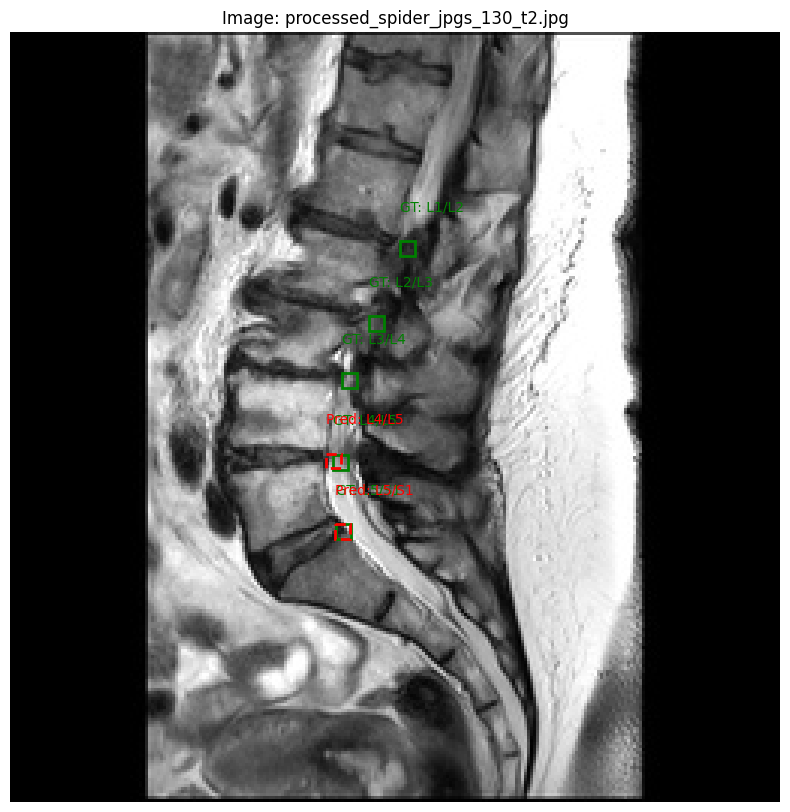

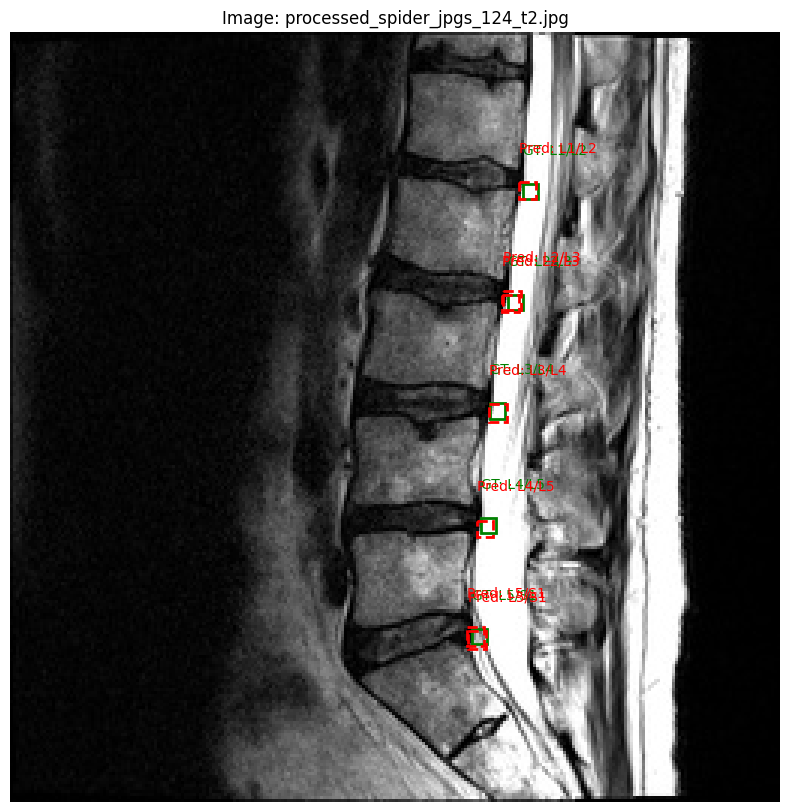

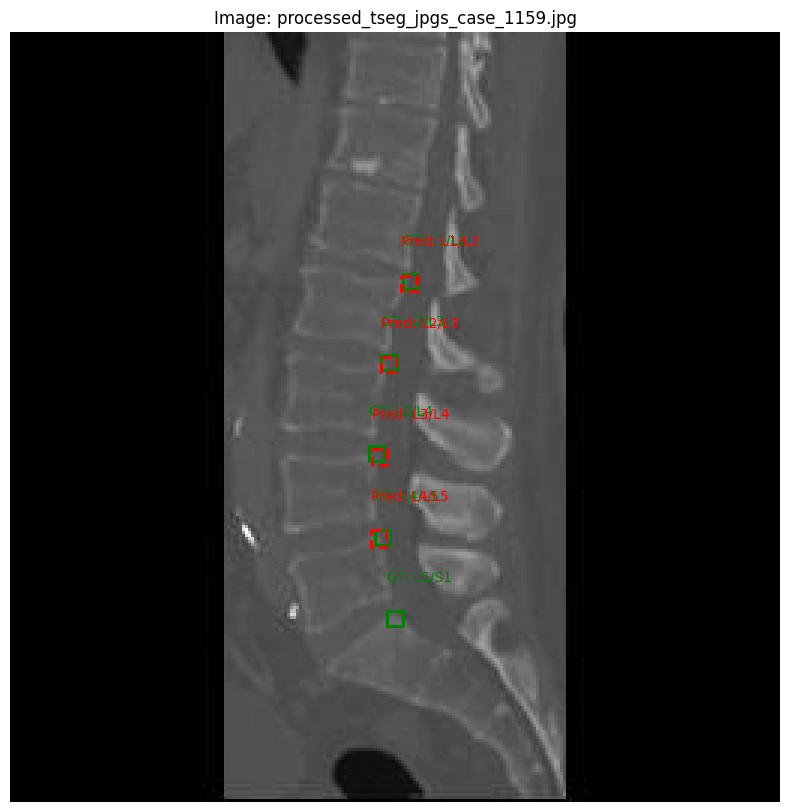

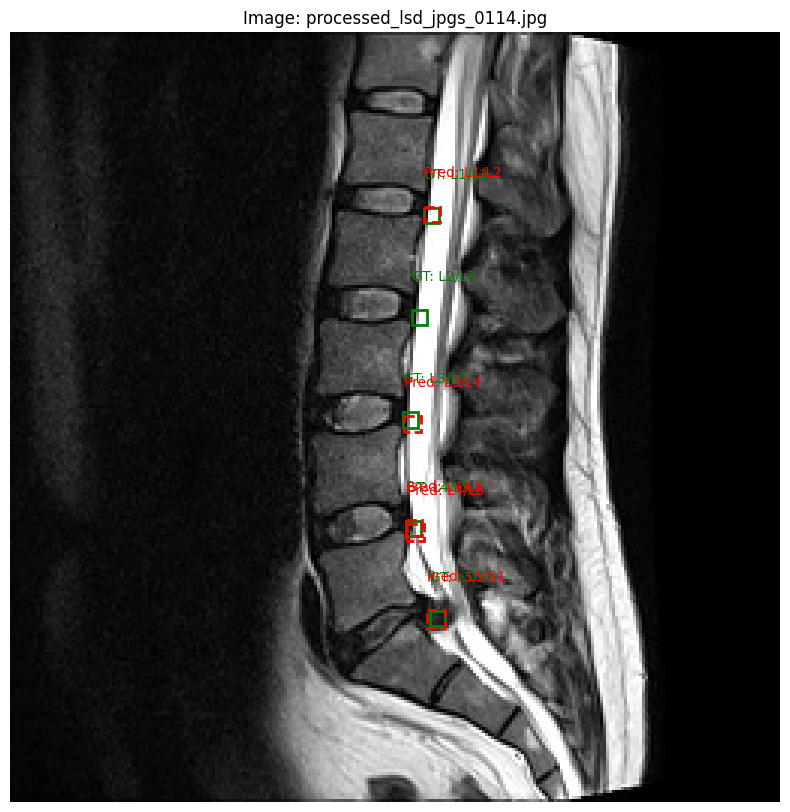

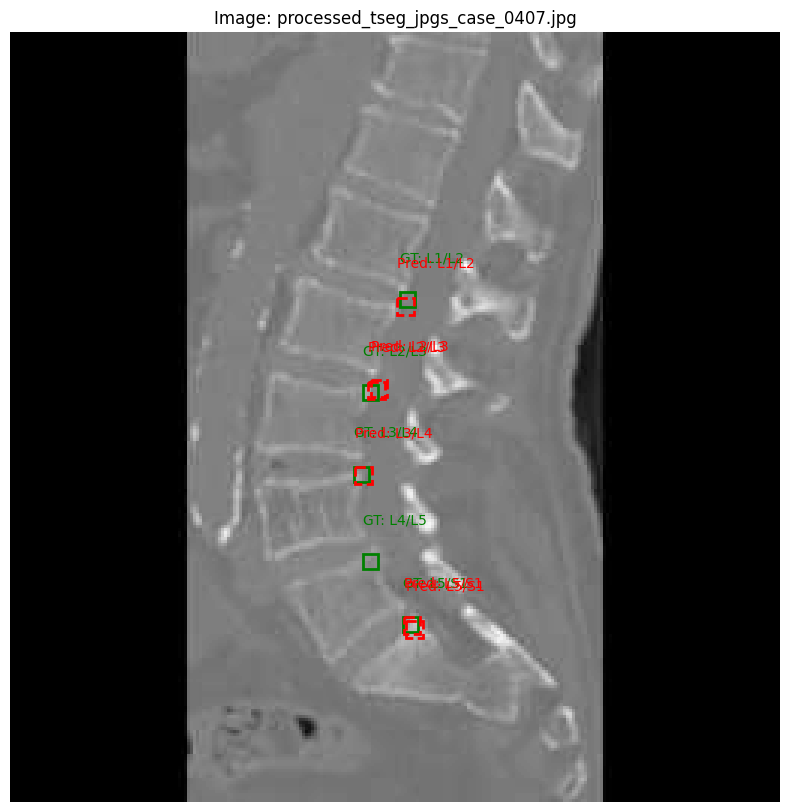

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

# Paths to directories
ground_truth_dir = '/content/drive/MyDrive/Machine_Learning_Project2024/Data/test/labels'
prediction_dir = '/content/drive/MyDrive/Machine_Learning_Project2024/YOLO_labels'
image_dir = '/content/drive/MyDrive/Machine_Learning_Project2024/Data/test/images'

# Function to parse YOLO format files
def parse_yolo_format(label_path):
    with open(label_path, 'r') as f:
        boxes = []
        for line in f.readlines():
            cls, x_center, y_center, width, height = map(float, line.strip().split())
            boxes.append({'class': int(cls), 'x_center': x_center, 'y_center': y_center, 'width': width, 'height': height})
        return boxes

# Function to convert YOLO bounding boxes to corner format [x_min, y_min, x_max, y_max]
def yolo_to_corners(boxes, img_width, img_height):
    converted_boxes = []
    for box in boxes:
        x_min = (box['x_center'] - box['width'] / 2) * img_width
        y_min = (box['y_center'] - box['height'] / 2) * img_height
        x_max = (box['x_center'] + box['width'] / 2) * img_width
        y_max = (box['y_center'] + box['height'] / 2) * img_height
        converted_boxes.append({'class': box['class'], 'x_min': x_min, 'y_min': y_min, 'x_max': x_max, 'y_max': y_max})
    return converted_boxes

# Class names for labels (ensure they match your dataset)
class_names = ['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']

# Colors for visualization
ground_truth_color = 'green'
prediction_color = 'red'

# Randomly select 5 images from the test set
random_images = random.sample(os.listdir(image_dir), 5)

for img_name in random_images:
    # Load image
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path)
    img_width, img_height = img.size

    # Load ground truth and predictions
    gt_label_path = os.path.join(ground_truth_dir, img_name.replace('.jpg', '.txt'))
    pred_label_path = os.path.join(prediction_dir, img_name.replace('.jpg', '.txt'))

    # Parse ground truth and predictions
    gt_boxes = parse_yolo_format(gt_label_path) if os.path.exists(gt_label_path) else []
    pred_boxes = parse_yolo_format(pred_label_path) if os.path.exists(pred_label_path) else []

    # Convert bounding boxes to corner format
    gt_boxes = yolo_to_corners(gt_boxes, img_width, img_height)
    pred_boxes = yolo_to_corners(pred_boxes, img_width, img_height)

    # Create a new figure for each image
    plt.figure(figsize=(10, 10))
    if img.mode == 'L':  # Grayscale image
        plt.imshow(img, cmap='gray')  # Use grayscale colormap
    else:  # RGB image
        plt.imshow(img)  # Display as is

    ax = plt.gca()  # Get the current axis

    # Plot ground truth boxes
    for box in gt_boxes:
        rect = Rectangle((box['x_min'], box['y_min']),
                         box['x_max'] - box['x_min'],
                         box['y_max'] - box['y_min'],
                         linewidth=2, edgecolor=ground_truth_color, facecolor='none')
        ax.add_patch(rect)
        plt.text(box['x_min'], box['y_min'] - 10, f"GT: {class_names[box['class']]}", color=ground_truth_color, fontsize=10)

    # Plot predicted boxes
    for box in pred_boxes:
        rect = Rectangle((box['x_min'], box['y_min']),
                         box['x_max'] - box['x_min'],
                         box['y_max'] - box['y_min'],
                         linewidth=2, edgecolor=prediction_color, facecolor='none', linestyle='--')
        ax.add_patch(rect)
        plt.text(box['x_min'], box['y_min'] - 10, f"Pred: {class_names[box['class']]}", color=prediction_color, fontsize=10)

    # Add title and remove axes
    plt.title(f"Image: {img_name}")
    plt.axis('off')
    plt.show()

In [ ]:
import shutil

# Path to the trained model weights (best.pt)
trained_model_path = '/content/runs/detect/train3/weights/best.pt'

# Destination path in Google Drive
destination_path = '/content/drive/MyDrive/Machine_Learning_Project2024/weights/best.pt'

# Copy the model to Google Drive
shutil.copy(trained_model_path, destination_path)

print(f"Model saved to: {destination_path}")

Model saved to: /content/drive/MyDrive/Machine_Learning_Project2024/weights/best.pt


In [ ]:
model = YOLO('/Users/decoliu/Downloads/best.pt')

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

# Path to your testing dataset
test_dataset_path = '/Users/decoliu/Downloads/images'  # Update with your testing dataset path

# Load all image paths
image_paths = [os.path.join(test_dataset_path, img_name) for img_name in os.listdir(test_dataset_path)]

# Split dataset into 4 folds
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# DataFrame to store results
results_list = []

# Iterate through each fold
for fold_index, (train_idx, test_idx) in enumerate(kf.split(image_paths)):
    print(f'Processing Fold {fold_index + 1}')
    fold_image_paths = np.array(image_paths)[test_idx]

    # Iterate through all images in the fold
    for img_path in fold_image_paths:
        img_name = os.path.basename(img_path)
        img = cv2.imread(img_path)

        # Run YOLO inference
        results = model(img)

        # Get predictions from results
        predictions = results[0].boxes.data.cpu().numpy()  # Convert to numpy array for easier manipulation

        # Iterate through different square radii
        for radius in range(5, 35, 5):
            objects_detected = 0
            distances_to_edge = []

            # Iterate through each detected object
            for row in predictions:
                xmin, ymin, xmax, ymax, confidence, class_id = row
                x_center = (xmin + xmax) / 2
                y_center = (ymin + ymax) / 2

                # Create a square bounding box centered at (x_center, y_center) with side length = 2 * radius
                xmin_square = max(0, x_center - radius)
                xmax_square = min(img.shape[1], x_center + radius)
                ymin_square = max(0, y_center - radius)
                ymax_square = min(img.shape[0], y_center + radius)

                # Count the object if it falls within the square
                if xmin >= xmin_square and xmax <= xmax_square and ymin >= ymin_square and ymax <= ymax_square:
                    objects_detected += 1

                    # Calculate distance from object center to the edge of the square
                    distance_to_edge = min(
                        abs(x_center - xmin_square),
                        abs(xmax_square - x_center),
                        abs(y_center - ymin_square),
                        abs(ymax_square - y_center)
                    )
                    distances_to_edge.append(distance_to_edge)

            # Record results for this image and radius
            for distance in distances_to_edge:
                results_list.append({
                    'Fold': fold_index + 1,
                    'Image': img_name,
                    'Radius': radius,
                    'Objects_Detected': objects_detected,
                    'Distance_To_Edge': distance
                })

# Create DataFrame from results list and save to CSV
results_df = pd.DataFrame(results_list)
results_df.to_csv('/content/drive/MyDrive/Machine_Learning_Project2024/testing_results.csv', index=False)

Processing Fold 1

0: 256x256 1 L2/L3, 1 L5/S1, 637.8ms


In [ ]:
# Plot results for each fold
for fold in results_df['Fold'].unique():
    fold_data = results_df[results_df['Fold'] == fold]

    # Set up the plot for distance distribution and boxplot
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram for distance distribution
    axs[0].hist(fold_data['Distance_To_Edge'], bins=np.arange(0, 35, 5), color='blue', alpha=0.7)
    axs[0].set_title(f'Fold {fold} Distance Distribution')
    axs[0].set_xlabel('Distance (pixels)')
    axs[0].set_ylabel('Frequency')

    # Boxplot for distance distribution
    axs[1].boxplot(fold_data['Distance_To_Edge'], patch_artist=True, boxprops=dict(facecolor='cyan'))
    axs[1].set_title(f'Fold {fold} Distance Boxplot')
    axs[1].set_ylabel('Distance (pixels)')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


NameError: name 'results_df' is not defined